# Plot model comparisons

This notebook uses results from GCCCP_2021/results/ to generate plots to comparing distributions.


It contains function to calculate for each setup:

1. MSE/Pearson R between reconstructed counts and 'simulated/exact' means per cell (for simulated data only). Test/Train
2. MSE/Pearson R between reconstructed counts and 'observed counts' per cell (for simulated and real data).
Test/Train 
3. Nearest neighbor metrics: what percent of top N nearest neighbors are in same cluster? Test/Train
4. Average distance to cluster mean per cell (and average variance within clusters in distance to cluster mean)
5. Average distance between cluster means
6. Average distance between cluster means / average distance to cluster means
7. Silhouette clustering


In [108]:
# import argparse
# parser = argparse.ArgumentParser()

# parser.add_argument('--name', type=str)
# parser.add_argument('--data_dir', type=str)
# args = parser.parse_args()

# name = args.name
# data_dir = args.data_dir
# print(f'working on {name}')


import matplotlib.pyplot as plt


# System
import sys
sys.path.insert(0, '../analysis_scripts/')

# Math
import numpy as np
import torch
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
# colors
import matplotlib.colors as mcolors

# scvi
import anndata
import scanpy as sc

from calculate_metrics import *

# nearest neighbor classifiers and pearson correlation calculators
from sklearn.neighbors import KNeighborsClassifier 
from scipy import stats #function: stats.pearsonr(x,y)
    

# Define metric functions

1. MSE
2. Pearson correlation coefficient
3. Nearest neighbors (using euclidean distance)



In [109]:
def get_metrics(name,results_dict,index,simulated_params = None):
  ''' Given results_dict from model training, returns MSE between simulated/recon means, Pearson correlation between simulated/recon means,
  and percentage of N nearest neighbors in the same cluster assignment for all cells. 


  params
  ------
  name: name of data
  index: test or train index
  simulated params: IF you pass simulated params, will calculate MSE and Pearson R between simulated means 
        and reconstructed means \
        rather than observed counts and reconstructed means
  results_dict:  containing keys for each setup:
    ['X_{z}','runtime','df_history','params','recon_error','cell_type']


  outputs
  -------
  metric_dict containing keys:
    ['MSE','MSE',Pearson_R',Pearson_R','nearest_neighbors']
  '''

  # set up dictionary to store things in with the training setups as keys
    
    
  setups = list(results_dict.keys())
  metric_dict = { setup : {} for setup in setups}
  z = list(results_dict[setups[0]].keys())[0][2:]

    
  cluster_assignments_ = cluster_assignments[index]
  # get observed means and dispersions
  obs_means = adata[index,:].layers['counts'].toarray()

  for setup in setups:
    print(setup)

    setup_dict = results_dict[setup]

    setup_metric_dict = {}

    # unpack dictionary
    X_z = setup_dict[f'X_{z}'][index]
    print(X_z.shape)
    recon_means = setup_dict['params']['mean'][index,:]
    
    if simulated_params is not None:
        if 'const' in name:
            obs_means_U = 1/10**simulated_params[:,:,0]   
            obs_means_S = 1/10**simulated_params[:,:,1]        
            obs_means = np.concatenate((obs_means_U,obs_means_S),axis=1)    
        if 'bursty' in name:
            params = 10**simulated_params
            b,beta,gamma = params[:,:,0],params[:,:,1],params[:,:,2]
            obs_means_U = b/beta       
            obs_means_S = b/gamma        
            obs_means = np.concatenate((obs_means_U,obs_means_S),axis=1)
        if 'BVNB' in name:
            alpha = simulated_params[:,:,0]
            beta = 10**simulated_params[:,:,1]
            gamma = 10**simulated_params[:,:,2]
            obs_means_U =  alpha/beta     
            obs_means_S = alpha/gamma     
            obs_means = np.concatenate((obs_means_U,obs_means_S),axis=1)
    
    if simulated_params is None:
      
      setup_metric_dict['MSE'] = np.array([ calc_MSE_1D(recon_means[i],obs_means[i]) for i in range(len(X_z)) ])
      setup_metric_dict['Pearson_R'] = np.array([ stats.pearsonr(recon_means[i], obs_means[i])[0] for i in range(len(X_z)) ])

    elif simulated_params is not None:
      print(cluster_assignments[0])
      setup_metric_dict['MSE'] = np.array([ calc_MSE_1D(recon_means[i],obs_means[cluster_assignments[i]]) for i in range(len(X_z)) ])
      setup_metric_dict['Pearson_R'] = np.array([ stats.pearsonr(recon_means[i], obs_means[cluster_assignments_[i]])[0] for i in range(len(X_z)) ])

    setup_metric_dict['nearest_neighbors'] = nn_percentages(X_z,cluster_assignments_)

    metric_dict[setup] = setup_metric_dict

  return(metric_dict)


# =============================================================================================



# Load in data 

Now load in data and see if it works.

Run analysis.

Make nice plots.

In [110]:
# open a file, where you stored the pickled data
# name = 'bursty_20ct_many'
# data_dir = '../../data/simulated_data/'
name = 'B08_processed_hv'
data_dir = '../../data/allen/'
results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()


if 'ct' in name:
    simulated_params = np.load(f'../../data/simulated_data/{name}_params.npy')
else:
    simulated_params = None



# read in adata
adata = anndata.read_loom(data_dir+f'{name}.loom')

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [113]:
if 'const' in name and simulated_params != None:
            obs_means_U = 1/10**simulated_params[:,:,0]   
            obs_means_S = 1/10**simulated_params[:,:,1]        
            obs_means = np.concatenate((obs_means_U,obs_means_S),axis=1)    
if 'bursty' in name and simulated_params != None:
            params = 10**simulated_params
            b,beta,gamma = params[:,:,0],params[:,:,1],params[:,:,2]
            obs_means_U = b/beta       
            obs_means_S = b/gamma        
            obs_means = np.concatenate((obs_means_U,obs_means_S),axis=1)
if 'BVNB' in name and simulated_params != None:
            alpha = simulated_params[:,:,0]
            beta = 10**simulated_params[:,:,1]
            gamma = 10**simulated_params[:,:,2]
            obs_means_U =  alpha/beta     
            obs_means_S = alpha/gamma     
            obs_means = np.concatenate((obs_means_U,obs_means_S),axis=1)

In [114]:
cell_types = results_dict.pop('Cell Type')

if 'ct' not in name:
    cell_range = range(len(cell_types.unique()))
    cell_dict = {cell : i for i,cell in enumerate(cell_types.unique())}
    cluster_assignments = np.array([cell_dict[ct] for ct in cell_types])
    print(len(cluster_assignments))
else:
    cluster_assignments = np.array([int(ct[2:]) for ct in cell_types])
    
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')

6454


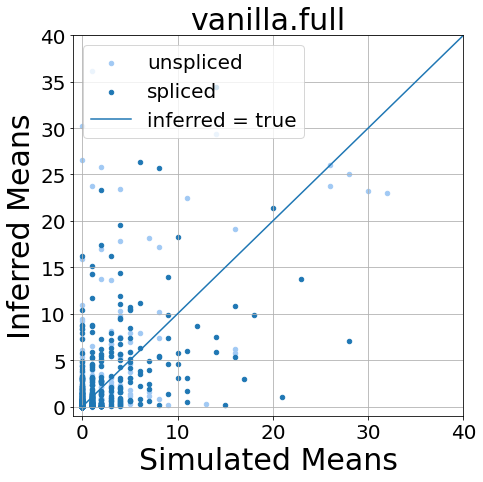

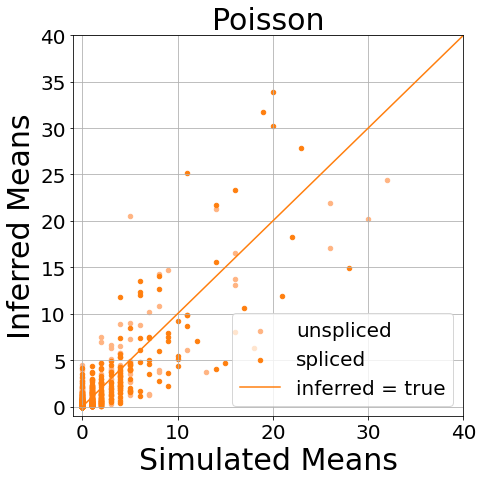

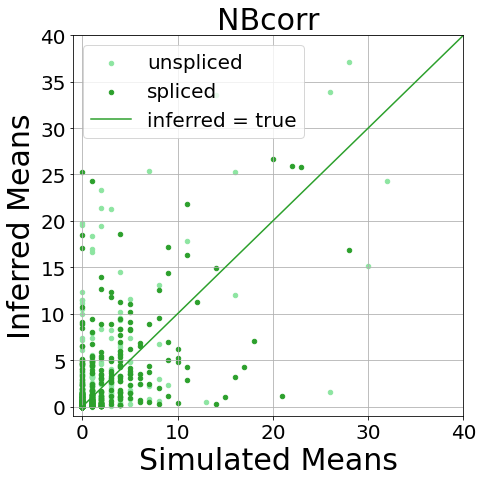

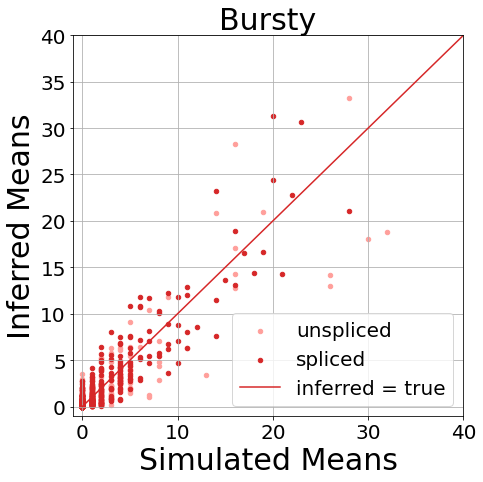

In [123]:
# plot true or observed means vs. recon means

i = 3
fs = 30


setups_to_compare = results_dict.keys()

# colors!!! 
color_dict = {setup : sns.color_palette()[i] for i,setup in enumerate(setups_to_compare)}
color_dict_u = {setup : sns.color_palette("pastel")[i] for i,setup in enumerate(setups_to_compare) }

obs_means = adata[i,:].layers['counts'].toarray()

for i,setup in enumerate(setups_to_compare):
    plt.figure(figsize=(7,7))
    reconstructed_means = results_dict[setup]['params']['mean']
#     plt.scatter(obs_means_U[cluster_assignments[i],:], reconstructed_means[i,:2000],color=color_dict_u[setup],s=20,label='unspliced')
#     plt.scatter(obs_means_S[cluster_assignments[i],:], reconstructed_means[i,2000:],color=color_dict[setup],s=20,label='spliced')
    
    plt.scatter(obs_means[0,:2000], reconstructed_means[i,:2000],color=color_dict_u[setup],s=20,label='unspliced')
    plt.scatter(obs_means[0,2000:], reconstructed_means[i,2000:],color=color_dict[setup],s=20,label='spliced')
    
    
    plt.plot(range(50),range(50),c=color_dict[setup],label='inferred = true')
    name_ = setup.split('-')[0]
    #pearson_r = stats.pearsonr(obs_means[cluster_assignments[i],:], reconstructed_means[i,:])[0]
    
    #plt.title(f'{name_}, Pearson R: {pearson_r:.3f}',fontsize=20)
    plt.title(f'{name_}',fontsize=fs)
    plt.xlabel('Simulated Means',fontsize=fs)
    plt.ylabel('Inferred Means',fontsize=fs)
    plt.xlim(-1,40)
    plt.ylim(-1,40)
    plt.grid()
    plt.legend(fontsize=20)
    plt.savefig(f'../../results/{name}_figs/example_mean_vs_mean_{setup}.png',bbox_inches = 'tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


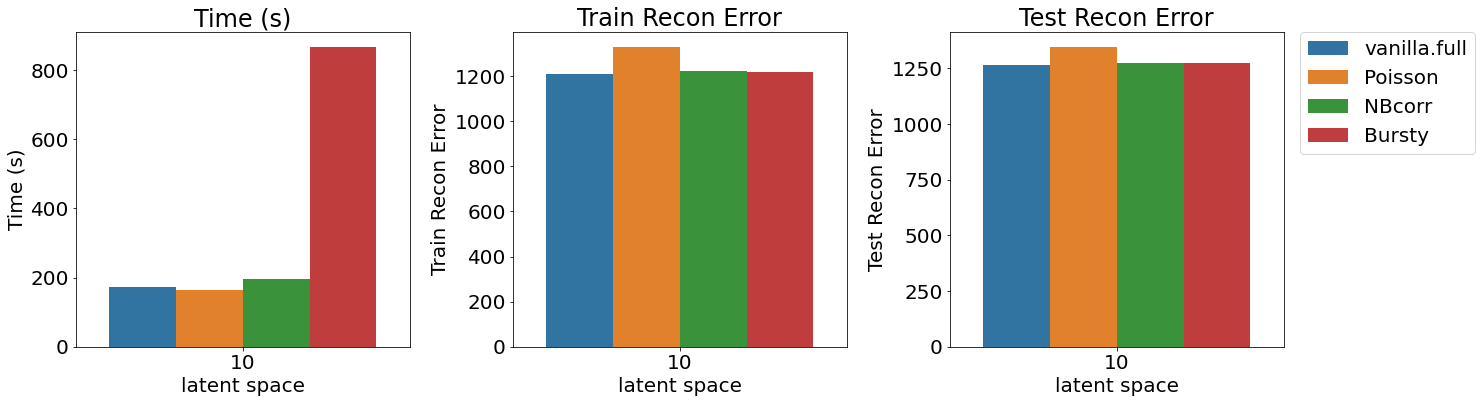

In [99]:
# # Plot Metrics
def plot_recon_loss(results_dict,kind):
  setups = list(results_dict.keys())

  df_plot = pd.concat([pd.DataFrame({'Train Recon Error': -1*np.array(item[1]['recon_error'])[0,1]['reconstruction_loss'],
               
                'Test Recon Error': -1*np.array(item[1]['recon_error'])[0,0]['reconstruction_loss'],
               
                'Time (s)': item[1]['runtime'][0],
                'Setup': item[0].split('-')[0],
                'latent space' : item[0].split('-')[1],
                'Constant' : item[0].split('-')[2]},index=[i]) for i,item in enumerate(results_dict.items())])



  fig,axes =plt.subplots(1,len(kind),figsize= (7*len(kind),6))
  for i,k in enumerate(kind):
      ax = axes[i]
      _ = sns.barplot(data=df_plot, x='latent space', y=k, hue='Setup', ax=ax)
      ax.get_legend().remove()
      ax.set_title(f'{k}')
      #ax.xticks(rotation=45)
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.tight_layout()

  return(df_plot)


plot_recon_loss(results_dict,kind=['Time (s)','Train Recon Error','Test Recon Error']);
plt.savefig(f'../../results/{name}_figs/recon_loss.png')


# Pot MSE, Pearson R, NN Accuracy

In [100]:
def get_df_plot(metric_df,metric):
  ''' Returns a dataframe in an easily plot-able format given metric_df and the metric targetted to plot. 
  '''

  plot_dict = {}

  for setup in metric_df.keys():

    print()
    setup_df = metric_df[setup]

    if metric in setup_df.keys():
 
      plot_dict[setup[:-13]] = setup_df[metric]
      

  if 'alpha' in metric:
    df_plot = pd.DataFrame(plot_dict,index=[0])
  else:
    df_plot = pd.DataFrame(plot_dict)
    
  return(df_plot)

def plot_metrics(metric_dict,name,metrics,T,zoom=None):
    
  fig,axes = plt.subplots(1,len(metrics),figsize= (8*len(metrics),10))
  print(len(axes))
  #plt.xticks(rotation=90)
  for i,m in enumerate(metrics):
    ax = axes[i]
    plot_df = get_df_plot(metric_dict,m)
    _ = sns.violinplot(x="variable", y="value", data=plot_df.melt().dropna(),ax=ax)
    ax.set_title(f'{name}, {m} {T}')
    ax.tick_params(labelrotation=90)
    if zoom is not None:
        ax.set_ylim(0,100)
    ax.set_xlabel('setup')
    ax.set_ylabel(f'{m}')
      #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    

### AND PLOT

vanilla.full-10-NAS_SHAPE
(5164, 10)


/home/tara/maria/scBIVI/GCCCP_2021/Code/Notebooks/../analysis_scripts/calculate_metrics.py:146: RuntimeWarning: invalid value encountered in true_divide
  nn_percent_cluster_ =  np.array([len(cluster_assignments[n][cluster_assignments[n]


Poisson-10-NAS_SHAPE
(5164, 10)


/home/tara/maria/scBIVI/GCCCP_2021/Code/Notebooks/../analysis_scripts/calculate_metrics.py:146: RuntimeWarning: invalid value encountered in true_divide
  nn_percent_cluster_ =  np.array([len(cluster_assignments[n][cluster_assignments[n]


NBcorr-10-NAS_SHAPE
(5164, 10)


/home/tara/maria/scBIVI/GCCCP_2021/Code/Notebooks/../analysis_scripts/calculate_metrics.py:146: RuntimeWarning: invalid value encountered in true_divide
  nn_percent_cluster_ =  np.array([len(cluster_assignments[n][cluster_assignments[n]


Bursty-10-NAS_SHAPE
(5164, 10)


/home/tara/maria/scBIVI/GCCCP_2021/Code/Notebooks/../analysis_scripts/calculate_metrics.py:146: RuntimeWarning: invalid value encountered in true_divide
  nn_percent_cluster_ =  np.array([len(cluster_assignments[n][cluster_assignments[n]


2












vanilla.full-10-NAS_SHAPE
(1290, 10)
Poisson-10-NAS_SHAPE
(1290, 10)
NBcorr-10-NAS_SHAPE
(1290, 10)
Bursty-10-NAS_SHAPE
(1290, 10)
2














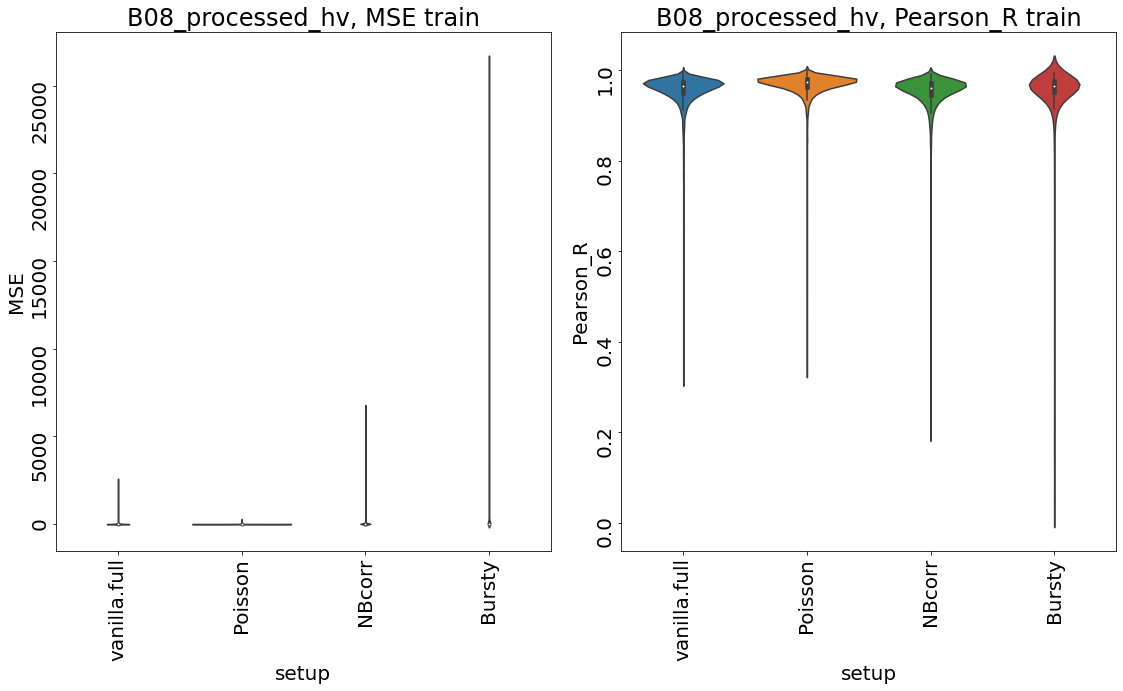

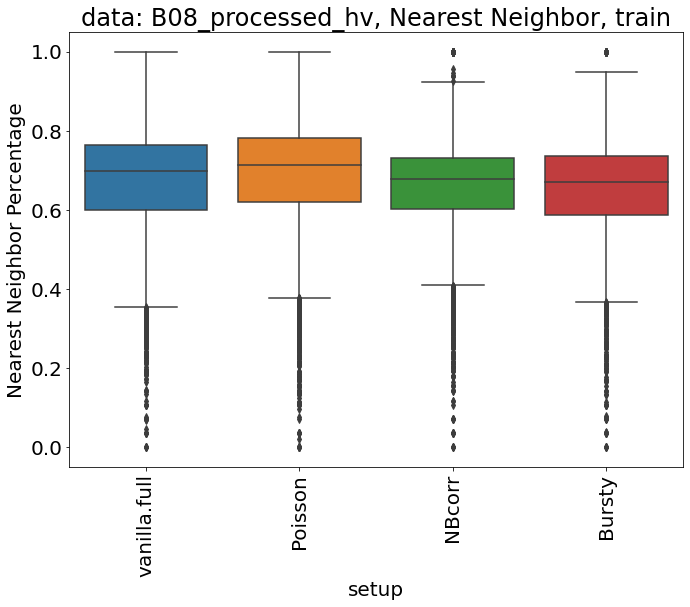

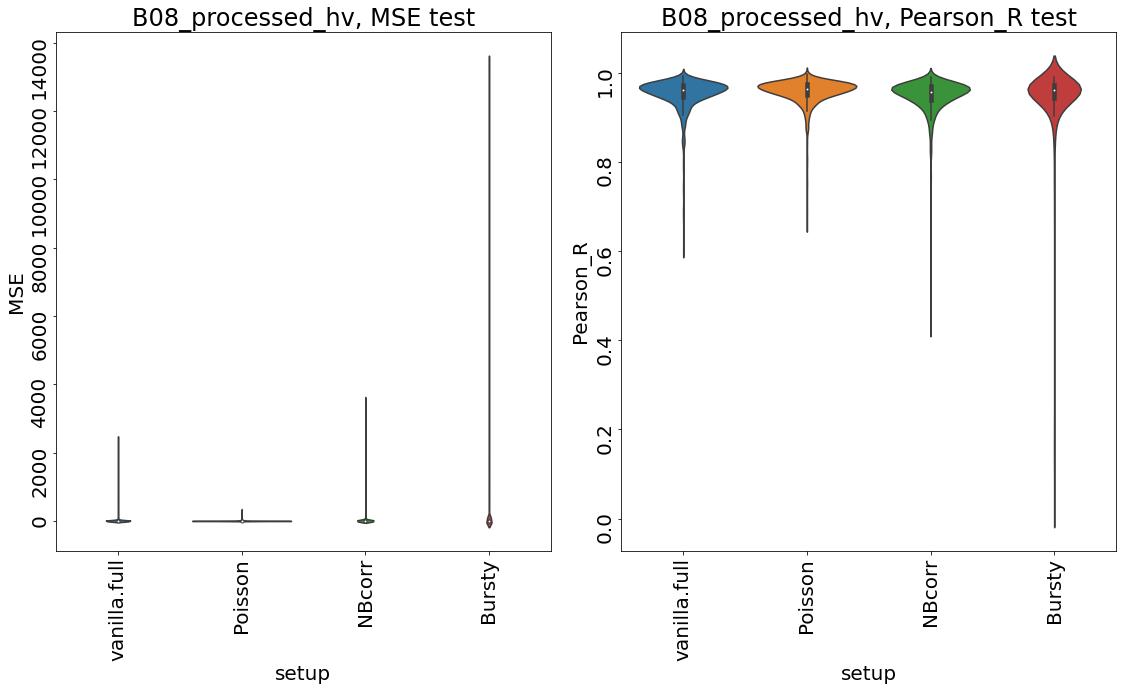

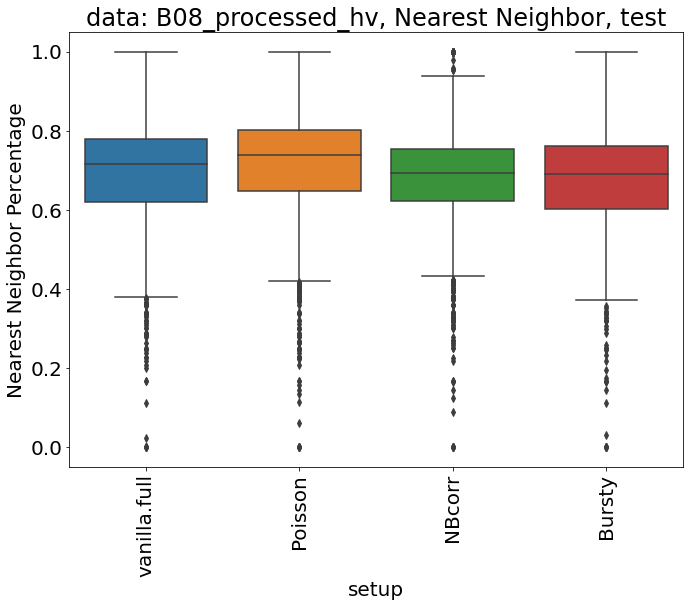

In [101]:
# # Calculate MSE, Pearson R, and Nearest Neighbor accuracy

for T in ['train','test']:
    
    if T == 'train':
        index = train_index
    if T == 'test':
        index = test_index
    
    
    metric_dict = get_metrics(name,results_dict,index,simulated_params)

    metrics = ['MSE','Pearson_R']
    plot_metrics(metric_dict,name,metrics,T,zoom=None)
    plt.savefig(f'../../results/{name}_figs/MSE_Pearson_R_{T}.png')

#     metrics = ['Pearson_R','Pearson_R']
#     plot_metrics(metric_dict,name,metrics,T)
    #plt.savefig(f'../results/{name}_figs/Pearson_R_{T}.png')

    plot_df = get_df_plot(metric_dict,metric='nearest_neighbors')
    plt.figure(figsize=(11, 8))
    sns.boxplot(x="variable", y="value", data=plot_df.melt().dropna())
    plt.xticks(rotation=90)
    plt.xlabel('setup')
    plt.ylabel('Nearest Neighbor Percentage')
    plt.title(f'data: {name}, Nearest Neighbor, {T}')
    plt.savefig(f'../../results/{name}_figs/nn_percentages_{T}.png')

-------

# scVI vs. biVI Paper Plots Figure 2

In [ ]:
fs= 30
metric = 'nearest_neighbors'
#sns.set(font_scale = 2)

setups_to_compare = ['Bursty-10-NAS_SHAPE']
setup_name_change = {'vanilla.full-10-NAS_SHAPE':'scVI','Bursty-10-NAS_SHAPE': 'biVI'}
plot_dict = {}

for setup in setups_to_compare:

    setup_df = metric_dict[setup]

    plot_dict[setup_name_change[setup]] = setup_df[metric]


df_plot = pd.DataFrame(plot_dict)
plt.figure(figsize=(11, 8))
#sns.stripplot(x="variable", y="value", data=df_plot.melt().dropna(),alpha=0.3)
sns.swarmplot(x="variable", y="value", data=df_plot.melt().dropna(),alpha=0.5)
sns.boxplot(x="variable", y="value", data=df_plot.melt().dropna())

#plt.xticks(rotation=90)
plt.xlabel('Method',fontsize=fs)
plt.ylabel('Nearest Neighbor Percentage',fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=fs)
#plt.title(f',metric} {T}')
#plt.ylim(0.2,1.03)
plt.savefig(f'../../results/{name}_figs/strip_mse_{T}_observed_means.png',bbox_inches = 'tight')

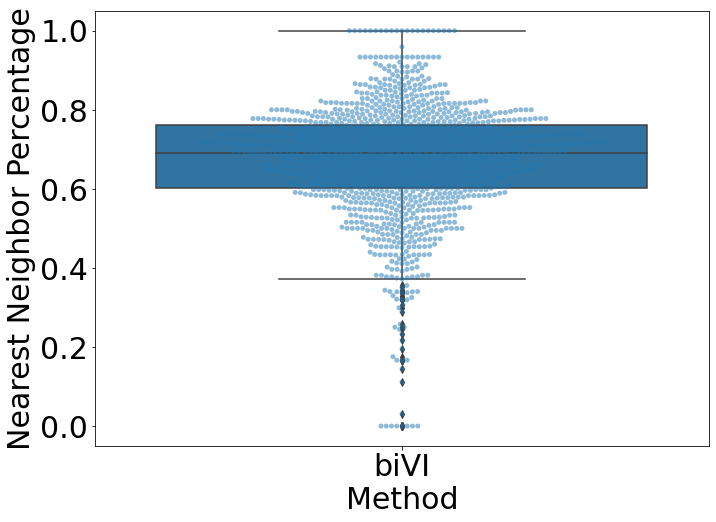

In [107]:
fs= 30
metric = 'nearest_neighbors'
#sns.set(font_scale = 2)

setups_to_compare = ['scVI-10-NAS_SHAPE','Bursty-10-NAS_SHAPE']
setup_name_change = {'vanilla.full-10-NAS_SHAPE':'scVI','Bursty-10-NAS_SHAPE': 'biVI'}
plot_dict = {}

for setup in setups_to_compare:

    setup_df = metric_dict[setup]

    plot_dict[setup_name_change[setup]] = setup_df[metric]


df_plot = pd.DataFrame(plot_dict)
plt.figure(figsize=(11, 8))
#sns.stripplot(x="variable", y="value", data=df_plot.melt().dropna(),alpha=0.3)
sns.swarmplot(x="variable", y="value", data=df_plot.melt().dropna(),alpha=0.5)
sns.boxplot(x="variable", y="value", data=df_plot.melt().dropna())

#plt.xticks(rotation=90)
plt.xlabel('Method',fontsize=fs)
plt.ylabel('Nearest Neighbor Percentage',fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=fs)
#plt.title(f',metric} {T}')
#plt.ylim(0.2,1.03)
plt.savefig(f'../../results/{name}_figs/strip_mse_{T}_observed_means.png',bbox_inches = 'tight')